# Getting started with `jaxmat`

In this tutorial, we show how to define and evaluate a simple elastoplastic behavior with nonlinear isotropic hardening.

We first import `jax` and may specify whether we want to run on the CPU or the GPU. We will also need the `equinox` package from which we use `Module`s to define the different behavior bricks, see [more details on the use of `equinox.Module`.](./../../docs/pytrees.md).

In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import equinox as eqx
import jaxmat.materials as jm

## Defining a behavior

In the `jaxmat.materials` module, various material models such as elasticity or von Mises plasticity are already available. We will use `LinearElasticIsotropic` for the elastic part and `vonMisesIsotropicHardening` for the elastoplastic model. The latter expects a yield stress module representing the isotropic hardening. In the following, we use a Voce-type exponential hardening:

$$
\sigma_\text{Y}(p) = \sigma_0 + (\sigma_\text{u}-\sigma_0)\exp(-bp)
$$

where $\sigma_0$ (resp. $\sigma_u$) is the initial (resp. final) yield stress and $b$ is a hardening parameter controlling the rate of convergence from $\sigma_0$ to $\sigma_u$ as a function of the cumulated plastic strain $p$.

For this purpose, we simply define an `equinox.Module` with the material parameter attributes $(\sigma_0,\sigma_u, b)$ and a `__call__` function which evaluates the current yield stress as a function of the cumulated plastic strain $p$.

In [2]:
elasticity = jm.LinearElasticIsotropic(E=200e3, nu=0.25)


class VoceHardening(eqx.Module):
    sig0: float
    sigu: float
    b: float

    def __call__(self, p):
        return self.sig0 + (self.sigu - self.sig0) * (1 - jnp.exp(-self.b * p))


hardening = VoceHardening(sig0=350.0, sigu=500.0, b=1e3)

We now define the final material behavior of type `vonMisesIsotropicHardening`. We can check that it is a module containing an `elastic_model` submodule and a `yield_stress` subdomule. Each of these submodule holds its own material properties. The elastic submodule also allows to access the material elastic shear modulus for instance, which is 80 GPa here.

In [3]:
material = jm.vonMisesIsotropicHardening(
    elastic_model=elasticity, yield_stress=hardening
)
print(material)
print(material.elastic_model.__dict__)
print(material.yield_stress.__dict__)

mu = elasticity.mu
print(f"\nShear modulus = {1e-3*mu} GPa")

vonMisesIsotropicHardening(
  elastic_model=LinearElasticIsotropic(E=f64[], nu=f64[]),
  yield_stress=VoceHardening(sig0=350.0, sigu=500.0, b=1000.0)
)
{'E': Array(200000., dtype=float64), 'nu': Array(0.25, dtype=float64)}
{'sig0': 350.0, 'sigu': 500.0, 'b': 1000.0}

Shear modulus = 80.0 GPa


Since `hardening` is a JAX function, we can also compute its derivative using `jax.grad` to obtain the corresponding hardening modulus. Below, we evaluate this modulus on an array of values of cumulated plastic strain and plot the result.

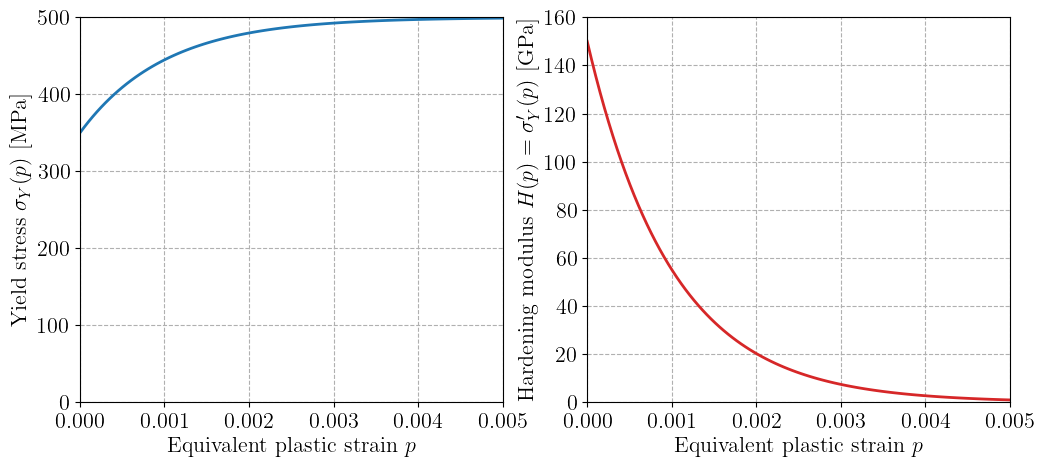

In [4]:
hardening_modulus = jax.grad(hardening)

p = jnp.linspace(0, 5e-3, 100)
H = jax.vmap(hardening_modulus)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(p, hardening(p), "-C0")
plt.gca().set_ylim(bottom=0)
plt.xlabel("Equivalent plastic strain $p$")
plt.ylabel("Yield stress $\sigma_Y(p)$ [MPa]")
plt.subplot(1, 2, 2)
plt.plot(p, 1e-3 * H(p), "-C3")
plt.gca().set_ylim(bottom=0)
plt.xlabel("Equivalent plastic strain $p$")
plt.ylabel("Hardening modulus $H(p)=\sigma_Y'(p)$ [GPa]")
plt.show()

## Mechanical states

In order to evaluate the response of a mechanical behavior, we need a mechanical state. Each material provides an `init_state` method to initialize its correponding mechanical state with default initial values (usually 0). Below, we see that the present state contrains a `strain` and a `stress`, each of them being a symmetric 2nd-rank tensor. In addition, it also contains an `internal` field, which is itself a state consisting of many internal state variables. In the present case, both the cumulated plastic strain $p$ and the total plastic strain $\bepsp$ are declared as internal state variables.

In [5]:
state = material.init_state()
print(state.__dict__)
internal_state_variables = material.internal
print(internal_state_variables.__dict__)

{'internal': InternalState(p=f64[], epsp=SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3])), 'strain': SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3]), 'stress': SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3])}
{'p': Array(0., dtype=float64), 'epsp': SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3])}


In [6]:
from jaxmat.tensors import SymmetricTensor2

gamma = 1e-3
new_eps = jnp.array([[0, gamma / 2, 0], [gamma / 2, 0, 0], [0, 0, 0]])
new_eps = SymmetricTensor2(tensor=new_eps)
dt = 0.0
new_stress, new_state = material.constitutive_update(new_eps, state, dt)
print(new_stress)
print(new_state.__dict__)

SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3])
{'internal': InternalState(p=f64[], epsp=SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3])), 'strain': SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3]), 'stress': SymmetricTensor2(dim=3, rank=2, _tensor=f64[3,3])}


In [7]:
gamma_list = jnp.linspace(0, 1e-2, 100)
state = material.init_state()
tau = jnp.zeros_like(gamma_list)
for i, gamma in enumerate(gamma_list):
    new_eps = jnp.array([[0, gamma / 2, 0], [gamma / 2, 0, 0], [0, 0, 0]])
    new_eps = SymmetricTensor2(tensor=new_eps)
    dt = 0.0
    new_stress, new_state = material.constitutive_update(new_eps, state, dt)
    state = new_state
    tau = tau.at[i].set(new_stress[0, 1])

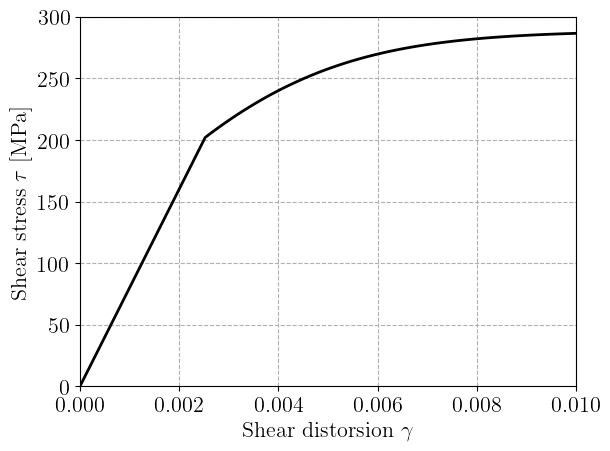

In [8]:
plt.plot(gamma_list, tau, "-k")
plt.xlabel(r"Shear distorsion $\gamma$")
plt.ylabel(r"Shear stress $\tau$ [MPa]")
plt.show()

In [9]:
tangent_operator = jax.jacfwd(material.constitutive_update, argnums=0, has_aux=True)

Let us now do the exact same calculation as before except that we call `tangent_operator` which now returns a tuple `(Ctang, new_state)` containing the tangent operator $\mathbb{C}_\text{tang}$ and the new material state. We have formally replaced the first output of `constitutive_update` with its Jacobian with respect to the applied strain. As a result, the stress is not directly returned as before. We can however retrieve it from the new state as `new_state.stress`.

In [10]:
gamma_list = jnp.linspace(0, 1e-2, 100)
state = material.init_state()
tau = jnp.zeros_like(gamma_list)
p = jnp.zeros_like(gamma_list)
mu_tang = jnp.zeros_like(gamma_list)
for i, gamma in enumerate(gamma_list):
    new_eps = jnp.array([[0, gamma / 2, 0], [gamma / 2, 0, 0], [0, 0, 0]])
    new_eps = SymmetricTensor2(tensor=new_eps)
    dt = 0.0
    Ctang, new_state = tangent_operator(new_eps, state, dt)
    state = new_state
    new_stress = state.stress
    tau = tau.at[i].set(new_stress[0, 1])
    p = p.at[i].set(state.internal.p)
    mu_tang = mu_tang.at[i].set(Ctang[0, 1, 0, 1])

Note that the tangent operator is the derivative of a `SymmetricTensor2` with respect to a `SymmetricTensor2` which is formally equivalent to a 4th-rank tensor. Its component can thus be accessed as `Ctang[i, j, k, l]`. Collecting the value of the tangent shear modulus from `Ctang[0, 1, 0, 1]`, its evolution clearly shows a first constant phase in the elastic regime where $\mu_\text{tang}=\mu=80\text{ GPa}$. We see the sudden drop at the onset of plasticity which is due to the finite initial hardening slope $R'(0)$. We know that the material (elastoplastic) tangent operator is given by:

$$\mathbb{C}^\text{ep} = 3\kappa\mathbb{J} + 2\mu\left(\mathbb{K}-\dfrac{3\mu}{3\mu+R'(p)}\boldsymbol{n}\otimes\boldsymbol{n}\right)$$
where $\boldsymbol{n}$ is the unit normal vector in the direction of the plastic flow. For pure shear conditions, this gives the elastoplastic tangent shear modulus:
$$
\mu^\text{ep} = \mu\left(1-\dfrac{3\mu}{3\mu+R'(p)}\right) = \mu\dfrac{R'(p)}{3\mu+R'(p)}
$$

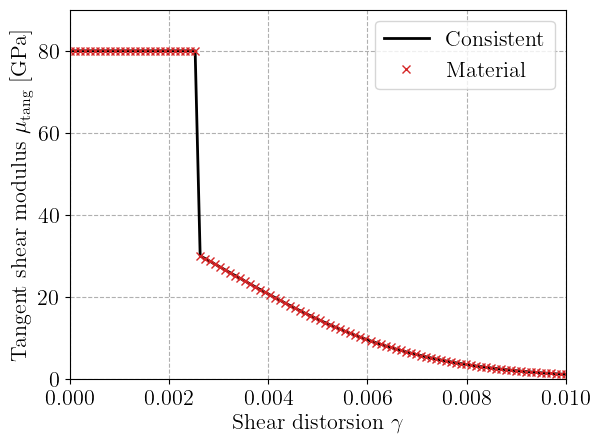

In [11]:
plt.plot(gamma_list, mu_tang * 1e-3, "-k", label="Consistent")
mu_ep = jnp.full_like(gamma_list, mu)
plastic_points = jnp.where(p > 1e-8)
H_plast = H(p[plastic_points])
mu_ep = mu_ep.at[plastic_points].set(mu * (H_plast / (3 * mu + H_plast)))
plt.plot(gamma_list, 1e-3 * mu_ep, "xC3", label="Material")
plt.ylim(0, 90)
plt.xlabel(r"Shear distorsion $\gamma$")
plt.ylabel(r"Tangent shear modulus $\mu_\textrm{tang}$ [GPa]")
plt.legend()
plt.show()